# Predictive Maintenance: Final Clean Notebook

In [2]:

import pandas as pd
import numpy as np

sensor_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\sensor_readings.csv")
sensor_df['Timestamp'] = pd.to_datetime(sensor_df['Timestamp'])
sensor_df['Date'] = sensor_df['Timestamp'].dt.date

sensor_df['Vibration'] = sensor_df['Vibration'].fillna(sensor_df['Vibration'].median())

Q1 = sensor_df['Temperature'].quantile(0.25)
Q3 = sensor_df['Temperature'].quantile(0.75)
IQR = Q3 - Q1
sensor_df = sensor_df[(sensor_df['Temperature'] >= Q1 - 1.5 * IQR) & (sensor_df['Temperature'] <= Q3 + 1.5 * IQR)]

daily_sensor = sensor_df.groupby(['MachineID', 'Date']).agg({
    'Temperature': 'mean',
    'Vibration': 'mean',
    'Pressure': 'mean',
    'RuntimeHours': 'sum'
}).reset_index()


In [3]:

maint_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\maintenance_logs.csv")
maint_df['Date'] = pd.to_datetime(maint_df['Date'], errors='coerce')
maint_df['RepairType'] = maint_df['RepairType'].fillna("Unknown")
maint_df['Failure'] = maint_df['Failure'].map({'Y': 1, 'N': 0})

meta_df = pd.read_csv(r"C:\Users\geeze\Downloads\Last Final Datasets\Task2\Datasets\machine_metadata.csv")
meta_df['LastOverhaulDate'] = pd.to_datetime(meta_df['LastOverhaulDate'])


In [4]:

daily_sensor['Date'] = pd.to_datetime(daily_sensor['Date'])
data = daily_sensor.merge(maint_df, on=['MachineID', 'Date'], how='left')
data = data.merge(meta_df, on='MachineID', how='left')
data['Failure'] = data['Failure'].fillna(0)
data['DaysSinceOverhaul'] = (data['Date'] - data['LastOverhaulDate']).dt.days

data = data.sort_values(['MachineID', 'Date'])
data['TempRollingAvg'] = data.groupby('MachineID')['Temperature'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['VibRollingAvg'] = data.groupby('MachineID')['Vibration'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
data['PresRollingAvg'] = data.groupby('MachineID')['Pressure'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

data['FailureInNext30Days'] = (
    data.groupby('MachineID')['Failure']
    .transform(lambda x: x.rolling(window=30, min_periods=1).max().shift(-1))
    .fillna(0).astype(int)
)


AUC-ROC: 0.66
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        71
           1       0.84      1.00      0.91       359

    accuracy                           0.84       430
   macro avg       0.92      0.53      0.51       430
weighted avg       0.87      0.84      0.78       430



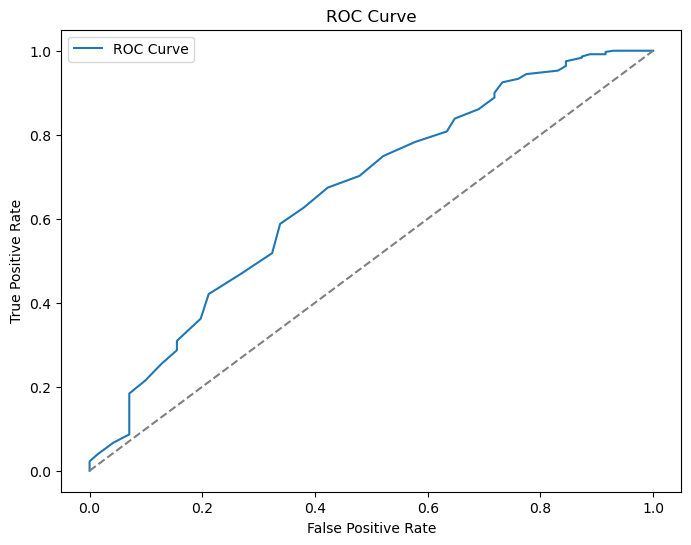

In [5]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model_df = data.dropna()
features = [
    'Temperature', 'Vibration', 'Pressure', 'RuntimeHours',
    'TempRollingAvg', 'VibRollingAvg', 'PresRollingAvg',
    'AgeYears', 'DaysSinceOverhaul'
]
X = model_df[features]
y = model_df['FailureInNext30Days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("AUC-ROC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [6]:

data['PredictedFailureProbability'] = clf.predict_proba(data[features])[:, 1]

daily_probs = data[['MachineID', 'Date', 'PredictedFailureProbability']]
daily_probs.to_csv("failure_probabilities_daily.csv", index=False)

latest = data.sort_values('Date').groupby('MachineID').tail(1)
top10 = latest.sort_values('PredictedFailureProbability', ascending=False).head(10)
top10['RecommendedMaintenanceDate'] = top10['Date'] + pd.Timedelta(days=3)

top10[['MachineID', 'PredictedFailureProbability', 'RecommendedMaintenanceDate', 'MachineType', 'AgeYears']].to_csv("top10_recommendations.csv", index=False)
